# Rewrite Code - Diffusion model
改變：
1. 只有$y_0$從 normal 裡面抽，沒有$x$
2. 'and not DETERMINISTIC' 拿掉
3. 輸出要看到eps

sorce code: Simple file

**目標**
* 利用neural network生成y_hat資料
* 比對y_true : 一堆N(0,1)生成的點(假裝不知道是normal)
* 假設檢定看y_hat跟y_true是否來自相同母群

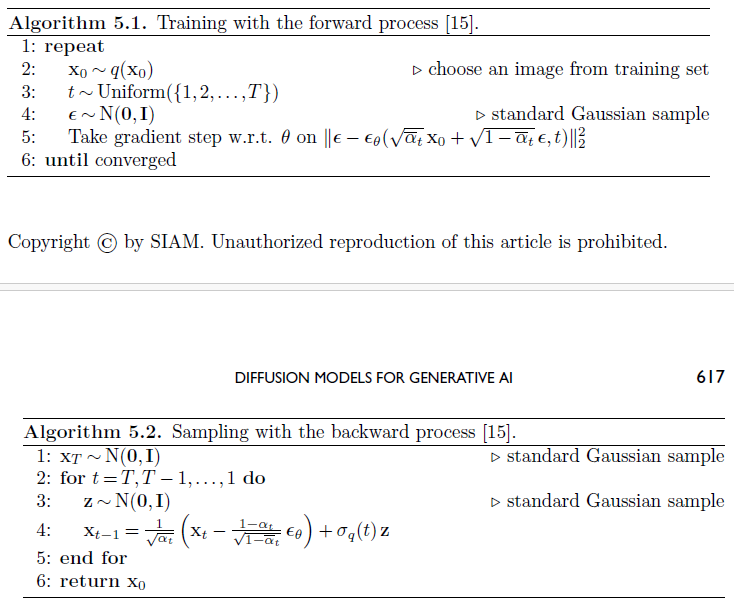


In [1]:
import math, torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt

### Con fig

In [2]:
DEVICE        = 'cpu' 
T             = 500        # diffusion steps
BATCH_SIZE    = 256
TRAIN_ITERS   = 2000       # 訓練步數
LR            = 2e-3
HIDDEN        = 128
TIME_DIM      = 64
N_TRAIN_SAMP  = 4096       # 訓練資料量）


In [3]:
### Constants setting
betas = torch.linspace(1e-4, 0.02, T+1, device=DEVICE)
alphas = 1.0-betas
abar = torch.cumprod(alphas, dim=0)
sqrt_abar = torch.sqrt(abar)
sqrt_lmabar = torch.sqrt(1.0-abar)
sqrt_rcp_a = torch.sqrt(1.0 / alphas)

In [4]:
### 這塊留給 time embedding
#-------------------------
def sinusoidal_time_emb(t, dim):
    # t: (B,) 的整數 timestep
    device = t.device
    t = t.float().unsqueeze(1)  # (B,1)
    half = dim // 2
    freqs = torch.exp(
        torch.arange(half, device=device).float() * (-math.log(10000.0) / max(1, half-1))
    )  # (half,)
    angles = t * freqs  # (B,half)
    emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=1)  # (B, 2*half)
    if dim % 2 == 1:  # 補一維避免奇數維崩
        emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=1)
    return emb  # (B, dim)

In [5]:
## 建nn
class EpsMLP(nn.Module):
    def __init__(self, hidden=HIDDEN, time_dim=TIME_DIM):
        super().__init__()
        self.time_dim = time_dim
        # 把 time embedding 投影到hidden layer
        self.t_proj = nn.Sequential(
            nn.Linear(time_dim, hidden), 
            nn.SiLU()
            )
        
        # y_t(1維) + time(hidden) → hidden → 1維噪聲預測
        in_dim = hidden + 1 # y+dim=1
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden,1)
        )
    def forward(self, y_t, t):
        t_emb = sinusoidal_time_emb(t, self.time_dim)   # (B, time_dim)
        h_t = self.t_proj(t_emb)                        # (B, hidden)
        h = torch.cat([y_t, h_t], dim=1)                # (B, 1+hidden)
        return self.net(h)

model = EpsMLP().to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=LR)

In [6]:
### 計算 y_t= sqrt(abar_t) y0 + sqrt(1-abar_t) * eps
# ---------------------
def q_sample(y0, t, eps=None):
    if eps is None:
        eps = torch.randn_like(y0)   ## 產生跟y0大小一樣的初始normal雜訊
    sa = sqrt_abar[t].view(-1,1)
    som = sqrt_lmabar[t].view(-1,1)
    return sa*y0+som*eps, eps


## Algorithm 1
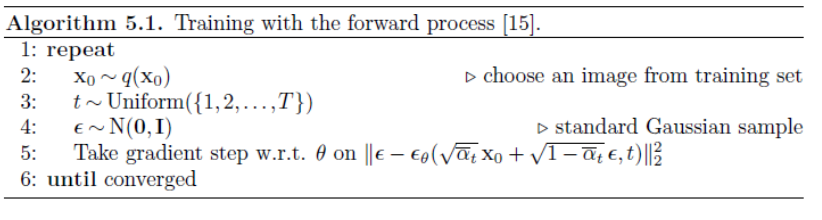

In [7]:
def train_loop():
    model.train()
    for step in range(1, TRAIN_ITERS+1):
        # 取 y0~N(0,1)
        y0 = torch.randn(BATCH_SIZE, 1, device=DEVICE)
        # 隨機time step
        t = torch.randint(2,T+1, (BATCH_SIZE,),device=DEVICE).long()
        # 向前加噪
        y_t, eps = q_sample(y0,t)
        # 預測噪音
        eps_hat = model(y_t, t)      ####<----已經把x去掉
        loss = F.mse_loss(eps_hat, eps)

        opt.zero_grad(set_to_none = True) ##要清空上次的gradient否則會累加
        loss.backward()
        #把L2norm限制在1.0以內避免梯度爆炸 ; 但如果loss穩定可以不用
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        if step % 100 ==0: ##每100步print紀錄一下 還有loss
            print(f"[train] step {step:4d} | loss {loss.item():.6f}")
        



## Algorithm 2
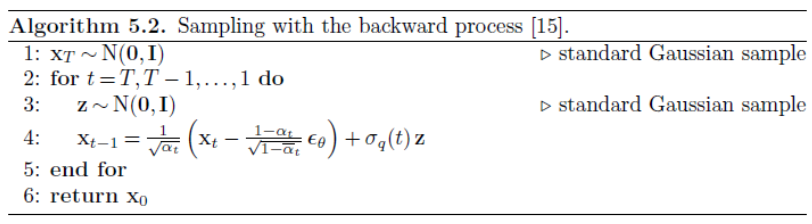

In [8]:
#@torch.no_grad() 是 PyTorch 的一個 decorator（裝飾器），加在函式前面，意思是：
#在這個函式裡面所有的張量運算，都不會被 autograd 記錄梯度。
#這樣可以減少計算消耗

@torch.no_grad()
def sample_on_grid(n_points = 401):
    model.eval()
    # 初始化 y 的 batch，要用 n_points
    y = torch.randn(n_points, 1, device=DEVICE)  ## 直接在N(0,1)裡面抽東西就好
    for t in reversed(range(T+1)):
        tb = torch.full((n_points,), t, device=DEVICE, dtype=torch.long)
        eps_hat = model(y, tb)  ###<<<---已拿掉x
        mean = sqrt_rcp_a[t]*(y - (betas[t]/sqrt_lmabar[t]) * eps_hat) #那行公式
        if t>0:
            y = mean + torch.sqrt(betas[t])*torch.randn_like(y)
        ###<----拿掉else
    
    return y.squeeze(1).cpu() 

---

## TEST

In [9]:
train_loop()
y_hat = sample_on_grid(n_points = 401)

[train] step  100 | loss 0.329363
[train] step  200 | loss 0.465059
[train] step  300 | loss 0.413109
[train] step  400 | loss 0.331199
[train] step  500 | loss 0.361054
[train] step  600 | loss 0.285095
[train] step  700 | loss 0.420927
[train] step  800 | loss 0.448808
[train] step  900 | loss 0.431658
[train] step 1000 | loss 0.255724
[train] step 1100 | loss 0.338137
[train] step 1200 | loss 0.391467
[train] step 1300 | loss 0.448572
[train] step 1400 | loss 0.335321
[train] step 1500 | loss 0.457090
[train] step 1600 | loss 0.456816
[train] step 1700 | loss 0.274925
[train] step 1800 | loss 0.321309
[train] step 1900 | loss 0.359863
[train] step 2000 | loss 0.504140


def truncated_normal_like(ref, mu=0.0, sigma=1.0, a=-1.0, b=1.0):
    out = torch.empty_like(ref)
    n = ref.numel()
    filled = 0
    while filled < n:
        # 先抽一批
        samples = torch.normal(mu, sigma, size=(n,), device=ref.device)
        # 保留區間內的
        samples = samples[(samples > a) & (samples < b)]
        take = min(samples.numel(), n - filled)
        out.view(-1)[filled:filled+take] = samples[:take]
        filled += take
    return out

 用法：跟 y_hat 對齊 shape
 在 (-1,1) 區間裡的 normal 分布樣本，那就需要用 截斷常態分布 (Truncated Normal)
 因為一般的 torch.randn 或 torch.normal 會產生整條實數線上的值。

y_true = truncated_normal_like(y_hat, mu=0.0, sigma=1.0, a=-1.0, b=1.0)

In [10]:
y_true = torch.randn(BATCH_SIZE, 1, device=DEVICE)

print("y_hat: ", y_hat)
print("y_true: ", y_true)   

y_hat:  tensor([ 6.9831e-01,  1.6941e+00, -4.7819e-01, -4.0352e-01,  4.2564e-01,
        -3.0137e-01,  1.6020e-01, -2.0212e+00,  5.3528e-01, -1.1268e+00,
         6.4147e-01,  1.6252e-01,  1.7012e+00,  2.0118e-01, -2.2840e+00,
         1.2426e+00,  9.2845e-02, -3.3716e-01,  1.5966e+00,  9.2759e-03,
        -5.9708e-01,  1.4283e-01, -1.2998e+00, -1.9089e+00,  3.2974e-01,
        -4.5639e-01,  6.5686e-01,  7.7547e-01, -2.4076e-01, -5.3802e-01,
        -1.7005e+00, -1.9203e-01, -5.1637e-01,  6.0581e-01,  6.8071e-01,
        -3.5672e-01,  1.0043e+00,  5.0622e-01,  6.9362e-01,  6.6931e-01,
        -1.9561e+00, -1.1511e-01, -8.7853e-01, -1.2585e-01,  3.6937e-01,
        -1.7248e+00, -5.9046e-01, -1.1087e+00, -1.8444e+00, -1.3466e+00,
        -4.4739e-01, -1.4721e+00,  1.8212e+00,  6.5739e-01, -1.0090e-01,
        -1.9009e+00,  2.6594e-01,  1.4986e+00,  1.9571e+00,  2.2576e+00,
         2.0036e-01, -1.0484e+00, -1.5880e+00,  5.2867e-01, -9.1507e-01,
        -2.7161e-01, -9.9876e-01,  1.1072e+

## Plot

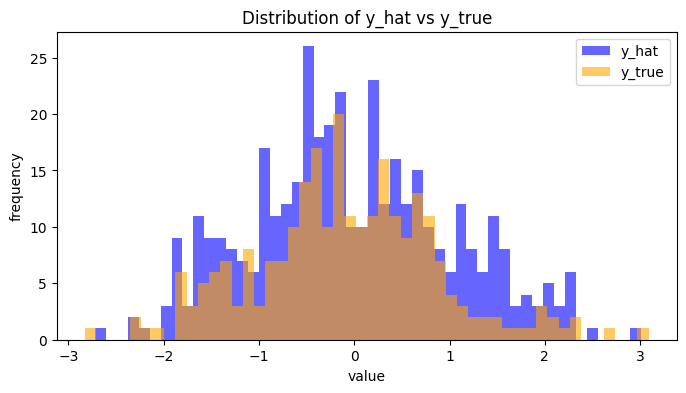

In [11]:
import matplotlib.pyplot as plt

# 如果在 GPU，要先搬回 CPU
y_hat_np = y_hat.detach().cpu().numpy().flatten()
y_true_np = y_true.detach().cpu().numpy().flatten()

plt.figure(figsize=(8,4))

# 畫 y_hat 的直方圖
plt.hist(y_hat_np, bins=50, alpha=0.6, color='blue', label='y_hat')

# 畫 y_true 的直方圖
plt.hist(y_true_np, bins=50, alpha=0.6, color='orange', label='y_true')

plt.legend()
plt.xlabel("value")
plt.ylabel("frequency")
plt.title("Distribution of y_hat vs y_true")
plt.show()


---

# NEW AREA -> Statistic Analysis
目標: 看y_hat跟y_true的母群是否相似 (POV:假裝不知道y_true是normal來的)


In [12]:
import numpy as np
from scipy.stats import ks_2samp, epps_singleton_2samp, levene, ttest_ind

In [13]:
# 1) 取資料（確保 shape 與裝置一致）
y_hat_np  = y_hat.detach().cpu().numpy().ravel()
y_true_np = y_true.detach().cpu().numpy().ravel()

# 2) 可選：讓樣本數一致（避免樣本量差異影響）
n = min(len(y_hat_np), len(y_true_np))
rng = np.random.default_rng(0)
y_hat_s  = rng.choice(y_hat_np,  n, replace=False)
y_true_s = rng.choice(y_true_np, n, replace=False)

# 3) 兩樣本分布檢定
ks_stat, ks_p = ks_2samp(y_hat_s, y_true_s)                 # KS 檢定（對整體CDF差異敏感）
es_stat, es_p = epps_singleton_2samp(y_hat_s, y_true_s)     # Epps–Singleton（對形狀差更敏感）

# 4) 均值、變異的簡單比較（非必要，但有助判讀差異來源）
t_stat, t_p   = ttest_ind(y_hat_s, y_true_s, equal_var=False)
lev_stat, lev_p = levene(y_hat_s, y_true_s)                 # 變異是否相等

print(f"KS: stat={ks_stat:.3f}, p={ks_p:.3g}")
print(f"Epps–Singleton: stat={es_stat:.3f}, p={es_p:.3g}")
print(f"t-test (means): stat={t_stat:.3f}, p={t_p:.3g}")
print(f"Levene (variances): stat={lev_stat:.3f}, p={lev_p:.3g}")

# 5) 幾個摘要統計（幫助你直覺比較）
def summary(a, name):
    print(name, "mean=", np.mean(a), "std=", np.std(a), "kurtosis≈", (np.mean(((a-np.mean(a))/np.std(a))**4)-3))
summary(y_hat_s,  "y_hat")
summary(y_true_s, "y_true")


KS: stat=0.082, p=0.356
Epps–Singleton: stat=10.943, p=0.0272
t-test (means): stat=0.282, p=0.778
Levene (variances): stat=5.433, p=0.0201
y_hat mean= -0.06739363 std= 1.0637249 kurtosis≈ -0.55951023
y_true mean= -0.092712305 std= 0.9590767 kurtosis≈ 0.43811393


### 分布比較結論

* $H_0$: 兩組資料之統計量(均值/變異)**相等**
* $H_a$: 兩組資料之統計量(均值/變異)**不相等**
* $p<0.05$ => 拒絕H_0

- **K-S test**  
  - stat=0.082, p=0.356  
  - 無顯著差異，整體 CDF 相近  

- **Epps–Singleton test**  
  - stat=10.943, p=0.0272  
  - 拒絕同分布假設  
  - 對尾部/形狀較敏感，顯示差異存在  

- **t-test (均值)**  
  - stat=0.282, p=0.778  
  - 均值無顯著差異  
  - y_hat ≈ -0.067, y_true ≈ -0.093  

- **Levene test (變異數)**  
  - stat=5.433, p=0.0201  
  - 變異數有顯著差異  
  - y_hat std=1.064 > y_true std=0.959  

### 總結
整體分布大致相近，但形狀與變異數仍存在顯著差異。


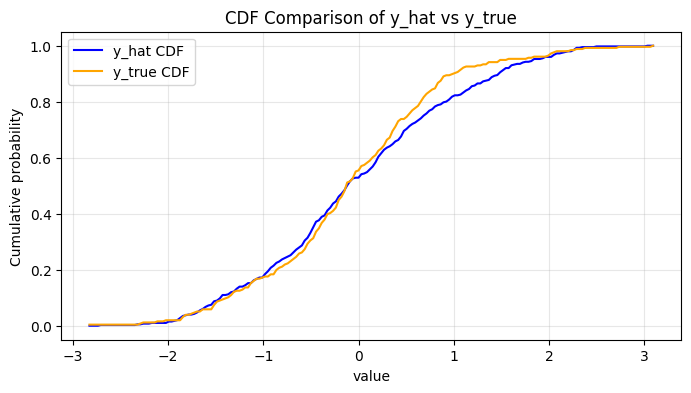

In [14]:
def plot_cdf_comparison(y_hat, y_true, bins=200):
    # 轉 numpy
    y_hat_np  = y_hat.detach().cpu().numpy().ravel()
    y_true_np = y_true.detach().cpu().numpy().ravel()

    # 共同範圍
    lo = min(y_hat_np.min(), y_true_np.min())
    hi = max(y_hat_np.max(), y_true_np.max())
    grid = np.linspace(lo, hi, bins)

    # 計算 CDF
    y_hat_cdf  = np.searchsorted(np.sort(y_hat_np), grid, side="right") / len(y_hat_np)
    y_true_cdf = np.searchsorted(np.sort(y_true_np), grid, side="right") / len(y_true_np)

    
    plt.figure(figsize=(8,4))
    plt.plot(grid, y_hat_cdf, label="y_hat CDF", color="blue")
    plt.plot(grid, y_true_cdf, label="y_true CDF", color="orange")
    plt.xlabel("value")
    plt.ylabel("Cumulative probability")
    plt.title("CDF Comparison of y_hat vs y_true")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


plot_cdf_comparison(y_hat, y_true)
